# Report

Let's set the random seeds for reproducibility.

In [2]:
import numpy as np
import random
import torch

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


## Data Preprocessing

We will start by loading the data for the Apple stock and inspecting their first few rows.

In [3]:
import yfinance as yf
import pandas as pd

# Download Apple stock data
stock_prices = yf.download('AAPL', 
                   start='2015-01-01', 
                   end='2024-01-31')

# Display the first few rows
print("First few rows of Apple stock data:")
stock_prices.head()

[*********************100%***********************]  1 of 1 completed

First few rows of Apple stock data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.373955,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000


Let's examine the path of the stock's closing price over time.

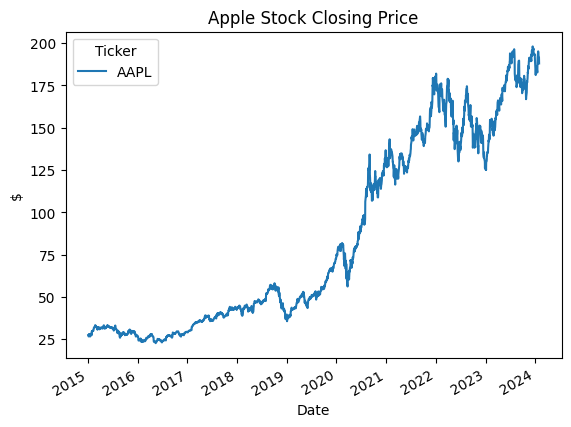

In [4]:
import matplotlib.pyplot as plt

stock_prices['Close'].plot()
plt.title('Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()



The stock price has a clear upward (multiplicative) trend over time as expected from such a tech company. There is a dip in early 2019 and 2020 probably due to the COVID-19 pandemic, which is followed by a signigicant growh rate. The volatility seems to be inceasing as the price is increasing.

Let's check for any missing values in the dataset.


In [5]:
# Check for missing values in the dataset
stock_prices.isnull().sum()

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

There are no missing values in the dataset.

We proceed with the calculation of the daily returns. We expect to have only one missing value in the daily returns due to the nature of the calculation.

We then define the extreme events, which will act as our target variable.

In [6]:
# Calculate the daily returns
stock_prices['Daily_Returns'] = stock_prices['Adj Close'].pct_change() * 100

# Remove the first row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240


In [7]:
# Create the Extreme_Event column
stock_prices['Extreme_Event'] = (abs(stock_prices['Daily_Returns']) > 2).astype(int)
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,1
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429,0
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214,0
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223,1
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240,0


We expect that the dataset will be imbalanced. Let's verify that.

In [8]:
# Count the number of extreme events
extreme_events = stock_prices[stock_prices['Extreme_Event'] == 1]
print(f"Number of extreme events: {len(extreme_events)}")

# Print the percentage of extreme events and no extreme events in the dataset
print(f"Percentage of extreme events: {len(extreme_events) / len(stock_prices) * 100:.2f}%")
print(f"Percentage of no extreme events: {(len(stock_prices) - len(extreme_events)) / len(stock_prices) * 100:.2f}%")



Number of extreme events: 460
Percentage of extreme events: 20.15%
Percentage of no extreme events: 79.85%


**The dataset is moderately imbalanced with approximately 20% of the data being extreme events. This is a challenge that we will have to address in the modelling phase.**

Our choices for doing so are limited, since we are dealing with a time-series dataset and we need to preserve the temporal nature of the data, which excludes the use of resampling techniques.

For the random forest model, we will scale the loss function using the class weights.

Next, we shift the target variable `Extreme_Event` by one day so that the model is trained to predict if an extreme event occurs **tomorrow** based on today's data.

In [9]:
# Shift the Extreme_Event column by one day
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].shift(-1)

# Remove the last row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].astype(int)
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,0
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429,0
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214,1
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223,0
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240,1


We continue by splitting the data into training, validation and test sets.


In [10]:
# Extract features and labels
features = stock_prices[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Returns']]
labels = stock_prices['Extreme_Event'].astype(int)  # Target variable

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.85

# Split into train, validation and test sets
train_size = int(train_ratio * len(stock_prices))
val_size = int(val_ratio * len(stock_prices))

X_train = features.iloc[:train_size]
y_train = labels.iloc[:train_size]

X_val = features.iloc[train_size:val_size]
y_val = labels.iloc[train_size:val_size]

X_test = features.iloc[val_size:]
y_test = labels.iloc[val_size:]

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1597, 6), labels shape: (1597,)
Validation features shape: (342, 6), labels shape: (342,)
Test features shape: (343, 6), labels shape: (343,)


Let's check the distribution of labels in the training, validation and test sets. We want to avoid underestimating the performance of the model on unseen data, due to total lack of positive examples.

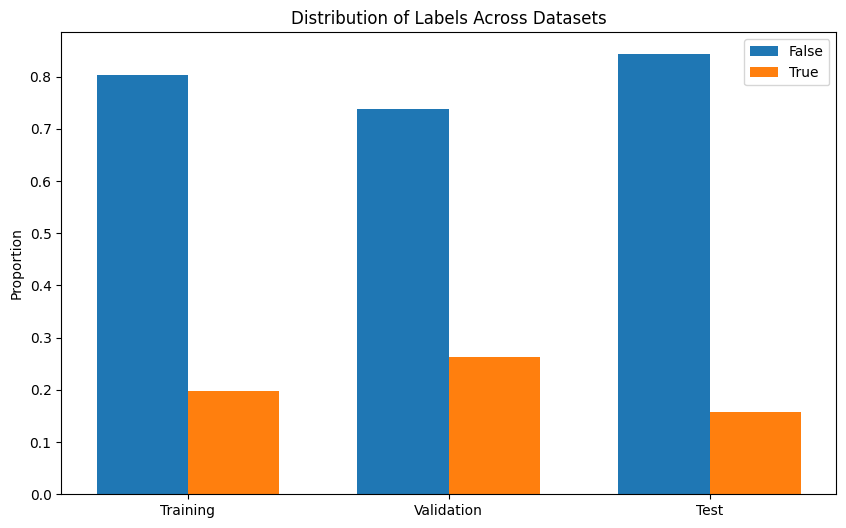

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate distributions
train_dist = y_train.value_counts() / len(y_train)
val_dist = y_val.value_counts() / len(y_val)
test_dist = y_test.value_counts() / len(y_test)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

# Group bars by False/True
false_vals = [train_dist[0], val_dist[0], test_dist[0]]
true_vals = [train_dist[1], val_dist[1], test_dist[1]]

ax.bar(x - width/2, false_vals, width, label='False')
ax.bar(x + width/2, true_vals, width, label='True')

ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Validation', 'Test'])
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Labels Across Datasets')
ax.legend()

plt.show()


The distribution of labels is similar across the datasets, so we can procced with fitting the models.

As a final step of preprocessing, we will transform the data into a more appropriate format for supervised learning. Specifically, for each day, we will create a sequence of historical features by going back 10 days. Hence, since we the dataset has 6 features, we will end up with 60 features for each day. The corresponding label will be 1 if an extreme event occurs tomorrow and 0 otherwise.

In [12]:
from src.data_preprocessing import StockDataPreprocessor

X_train, y_train = StockDataPreprocessor.time_series_to_supervised(
        X_train, y_train, lookback=10
    )
X_val, y_val = StockDataPreprocessor.time_series_to_supervised(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.time_series_to_supervised(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")


Training features shape: (1587, 60), labels shape: (1587,)
Validation features shape: (332, 60), labels shape: (332,)
Test features shape: (333, 60), labels shape: (333,)


Let's examine the first few rows of the training set. For each feature, we will have 10 days of history, amounting to 60 featurs in total.

In [13]:
print(f'Shape of the training set: {X_train.shape}')
X_train.head()


Shape of the training set: (1587, 60)


,Open(t-10),High(t-10),Low(t-10),Close(t-10),Volume(t-10),Daily_Returns(t-10),Open(t-9),High(t-9),Low(t-9),Close(t-9),...,Low(t-2),Close(t-2),Volume(t-2),Daily_Returns(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Daily_Returns(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-20 00:00:00+00:00,27.072500,27.162500,26.352501,26.562500,257142000.0,-2.817190,26.635000,26.857500,26.157499,26.565001,...,26.665001,26.705000,240056000.0,-2.714028,26.757500,26.895000,26.299999,26.497499,314053200.0,-0.777023
2015-01-21 00:00:00+00:00,26.635000,26.857500,26.157499,26.565001,263188400.0,0.009429,26.799999,27.049999,26.674999,26.937500,...,26.299999,26.497499,314053200.0,-0.777023,26.959999,27.242500,26.625000,27.180000,199599600.0,2.575719
2015-01-22 00:00:00+00:00,26.799999,27.049999,26.674999,26.937500,160423600.0,1.402182,27.307501,28.037500,27.174999,27.972500,...,26.625000,27.180000,199599600.0,2.575719,27.237499,27.764999,27.067499,27.387501,194303600.0,0.763421
2015-01-23 00:00:00+00:00,27.307501,28.037500,27.174999,27.972500,237458000.0,3.842256,28.167500,28.312500,27.552500,28.002501,...,27.067499,27.387501,194303600.0,0.763421,27.565001,28.117500,27.430000,28.100000,215185600.0,2.601555
2015-01-26 00:00:00+00:00,28.167500,28.312500,27.552500,28.002501,214798000.0,0.107247,28.150000,28.157499,27.200001,27.312500,...,27.430000,28.100000,215185600.0,2.601555,28.075001,28.437500,27.882500,28.245001,185859200.0,0.516007


# Random Forest Model

Now we will proceed with fitting the random forest model. Since we are using a tree-based model, we will not normalize the data.

In order to tune the hyperparameters of the random forest model, we will use the `hyperopt` library. It uses a Bayesian optimization approach to find the best hyperparameters, called `Tree of Parzen Estimators` (TPE). 

The choice of metric for the optimization is nuanced when dealing with imbalanced datasets and one should consider what is the cost of the false negatives and false positives. In our case, a false positive would mean that we falsely predict an extreme event for the next day, which could lead to a loss of capital and trust in the model. On the other hand, a false negative would mean that we falsely predict no extreme event for the next day, which could lead to a loss of potential profits. 

Precision is preffered when false positives are more costly and recall is preffered when false negatives are more costly. Assuming that we are not higly risk averse, i.e. we are willing to lose some money in order to make a profit, we will use the metric $F2$ with $\beta = 2$ as our optimization metric, which weighs recall more heavily than precision.

$F2$ is defined as:

$F2 = (1 + 2^2) \cdot \frac{Precision \cdot Recall}{2^2 \cdot Precision + Recall}$,

where $Precision = \frac{TP}{TP + FP}$ and $Recall = \frac{TP}{TP + FN}$.



In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score

def objective(params):
    """
    Objective function for hyperopt optimization.
    """
    model_params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_leaf_nodes': int(params['max_leaf_nodes']),
        'max_features': params['max_features'],
        'min_impurity_decrease': params['min_impurity_decrease'],
        'criterion': 'entropy',  
        'class_weight': 'balanced',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = RandomForestClassifier(**model_params)
    model.fit(X_train.values, y_train.values.astype(int))
    
    # Evaluate on validation set
    y_pred = model.predict(X_val.values)
    f2 = fbeta_score(y_val.values.astype(int), y_pred, beta=2)
    
    return {'loss': -f2, 'status': STATUS_OK}

# Define search space
space = {
    'n_estimators': hp.quniform('n_estimators', 700, 800, 1),
    'max_depth': hp.quniform('max_depth', 70, 100, 1),
    'min_samples_split': hp.quniform('min_samples_split', 5, 15, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 3, 1),
    'max_features': hp.uniform('max_features', 0.8, 1.0),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 500, 600, 1),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.04, 0.05),
}



# Run optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print("\nBest trial:")
print(f"  Value (F2): {-min(trials.losses()):.4f}")
print("\nBest parameters:")
for key, value in best.items():
    print(f"    {key}: {value}")

100%|██████████| 30/30 [00:33<00:00,  1.13s/trial, best loss: -0.6432748538011696]

Best trial:
  Value (F2): 0.6433

Best parameters:
    max_depth: 85.0
    max_features: 0.8748844293254838
    max_leaf_nodes: 564.0
    min_impurity_decrease: 0.040156893421287414
    min_samples_leaf: 2.0
    min_samples_split: 7.0
    n_estimators: 706.0


We proceed with fitting the final model with the best parameters and evaluating on the test set.

In [15]:
# Train final model with best parameters
best_params = best.copy()
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_leaf_nodes'] = int(best_params['max_leaf_nodes'])

best_params.update({
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
})

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train.values, y_train.values.astype(int))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=85,
                       max_features=np.float64(0.8748844293254838),
                       max_leaf_nodes=564,
                       min_impurity_decrease=np.float64(0.040156893421287414),
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=706, n_jobs=-1, random_state=42)

Test Set Metrics:
----------------------------------------
F2 Score            : 0.4690
F1 Score            : 0.2611
Precision           : 0.1502
Recall              : 1.0000
Accuracy            : 0.1502
AUC                 : 0.5000
Balanced Accuracy   : 0.5000
----------------------------------------


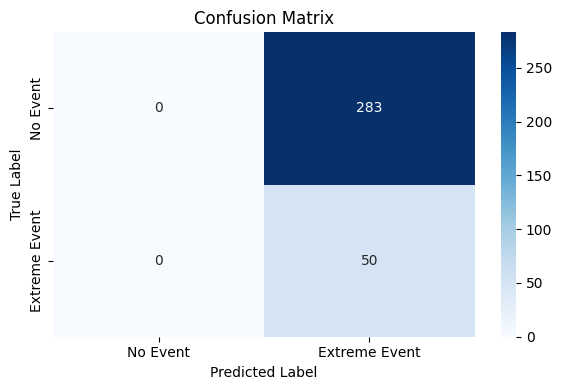

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, 
                           precision_score, recall_score, confusion_matrix, f1_score)

# Make predictions
y_pred = final_model.predict(X_test.values)
y_true = y_test.values.astype(int)

# Calculate metrics
metrics = {
    'F2 Score': fbeta_score(y_true, y_pred, beta=2),
    'F1 Score': fbeta_score(y_true, y_pred, beta=1),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Accuracy': accuracy_score(y_true, y_pred),
    'AUC': roc_auc_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
}

# Print metrics in a organized way
print("Test Set Metrics:")
print("-" * 40)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Event', 'Extreme Event'],
            yticklabels=['No Event', 'Extreme Event'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


We see that the model is prediciting all the test samples as extreme events, because of the metric used for optimization. It has not learned how to truly distinguish the two classes, hence we are severely underfitting the training data.

# Temporal CNN Model


Let's prepare the data for the temporal CNN model.

The dataset ought to have the shape `[batch_size, num_features, sequence_length]`.

Let's examine again the first few rows of the stock price dataframe. 

In [26]:
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687309,26.562500,27.162500,26.352501,27.072500,257142000,-2.817128,0
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009405,0
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214,1
2015-01-08 00:00:00+00:00,24.944681,27.972500,28.037500,27.174999,27.307501,237458000,3.842215,0
2015-01-09 00:00:00+00:00,24.971430,28.002501,28.312500,27.552500,28.167500,214798000,0.107232,1


In [11]:
from src.data_preprocessing import StockDataPreprocessor
stock_prices = StockDataPreprocessor.standardize_data(stock_prices, ['Open', 'High', 'Low', 'Close', 'Volume'])
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,-1.031309,-1.025440,-1.030020,-1.022063,1.965753,-2.817151,0
2015-01-06 00:00:00+00:00,23.689537,-1.031264,-1.030777,-1.033506,-1.029804,2.054466,0.009429,0
2015-01-07 00:00:00+00:00,24.021715,-1.024681,-1.027408,-1.024256,-1.026884,0.546695,1.402214,1
2015-01-08 00:00:00+00:00,24.944683,-1.006389,-1.010130,-1.015318,-1.017906,1.676948,3.842223,0
2015-01-09 00:00:00+00:00,24.971434,-1.005859,-1.005318,-1.008570,-1.002691,1.344479,0.107240,1


In [12]:
# Extract features and labels
features = stock_prices[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Returns']]
labels = stock_prices['Extreme_Event'].astype(int)  # Target variable

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.85

# Split into train, validation and test sets
train_size = int(train_ratio * len(stock_prices))
val_size = int(val_ratio * len(stock_prices))

X_train = features.iloc[:train_size]
y_train = labels.iloc[:train_size]

X_val = features.iloc[train_size:val_size]
y_val = labels.iloc[train_size:val_size]

X_test = features.iloc[val_size:]
y_test = labels.iloc[val_size:]

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1597, 6), labels shape: (1597,)
Validation features shape: (342, 6), labels shape: (342,)
Test features shape: (343, 6), labels shape: (343,)


In [13]:
from typing import Tuple

def create_sequences(X: pd.DataFrame, y: pd.Series, lookback: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences of lookback days for each feature, with corresponding labels.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Input features dataframe with datetime index
    y : pd.Series
        Input labels series with datetime index
    lookback : int
        Number of timesteps to look back (default: 10)
        
    Returns:
    --------
    X_seq : numpy.ndarray
        Array of shape [n_samples, n_features, lookback]
    y_seq : numpy.ndarray
        Array of labels
    """
    n_features = X.shape[1]
    n_samples = len(X) - lookback
    
    # Initialize arrays
    X_seq = np.zeros((n_samples, n_features, lookback))
    y_seq = np.zeros(n_samples)
    
    # Create sequences
    for i in range(n_samples):
        # Get sequence of lookback days for each feature
        sequence = X.iloc[i:i+lookback]
        # Store features (reverse order so most recent is last)
        X_seq[i] = sequence.T.values[:, ::-1]
        # Store label (the extreme event flag for the next day after sequence)
        y_seq[i] = y.iloc[i+lookback]
    
    return X_seq, y_seq

In [14]:
X_train, y_train = create_sequences(X_train, y_train, lookback=10)
X_val, y_val = create_sequences(X_val, y_val, lookback=10)
X_test, y_test = create_sequences(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1587, 6, 10), labels shape: (1587,)
Validation features shape: (332, 6, 10), labels shape: (332,)
Test features shape: (333, 6, 10), labels shape: (333,)


In [34]:
import lightning as L
import torch
import torch.nn as nn
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader, TensorDataset


class TCNN(L.LightningModule):
    def __init__(
        self,
        n_features: int,
        lookback: int,
        hidden_dim: int = 64,
        conv_channels: int = 32,
        kernel_size: int = 3,
        dropout_prob: float = 0.2,
        learning_rate: float = 1e-3,
    ):
        """
        Parameters:
        -----------
        n_features : int
            Number of input features
        lookback : int
            Number of timesteps to look back
        hidden_dim : int
            Dimension of hidden dense layer
        conv_channels : int
            Number of channels in first conv layer (second layer has 2x channels)
        kernel_size : int
            Size of convolutional kernel
        learning_rate : float
            Learning rate for optimizer
        """
        super().__init__()
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []

        # Definition of the CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv1d(
                in_channels=n_features,
                out_channels=conv_channels,
                kernel_size=kernel_size,
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Conv1d(
                in_channels=conv_channels,
                out_channels=conv_channels * 2,
                kernel_size=kernel_size,
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Flatten(),
            nn.Linear(
                (conv_channels * 2) * (lookback - 2 * kernel_size + 2), hidden_dim
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x: Input tensor of shape [batch_size, n_features, lookback]

        Returns:
            Predicted probabilities tensor of shape [batch_size, 1]
        """
        x = self.cnn(x)
        return torch.sigmoid(x)

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Performs a single training step.

        Args:
            batch: Tuple of (features, labels)
            batch_idx: Index of current batch

        Returns:
            Training loss value
        """
        x, y = batch
        y_hat = self(x)
        loss = nn.BCELoss()(y_hat, y.float().view(-1, 1))
        # Store training loss
        self.train_losses.append(loss.item())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Performs a single validation step.

        Args:
            batch: Tuple of (features, labels)
            batch_idx: Index of current batch

        Returns:
            Validation loss value
        """
        x, y = batch
        y_hat = self(x)
        loss = nn.BCELoss()(y_hat, y.float().view(-1, 1))
        # Store validation loss
        self.val_losses.append(loss.item())
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer for training.

        Returns:
            AdamW optimizer instance
        """
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


def train_tcnn_model(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    conv_channels: int = 32,
    kernel_size: int = 3,
    hidden_dim: int = 64,
    dropout_prob: float = 0.2,
    batch_size: int = 32,
    max_epochs: int = 100,
    patience: int = 10,
    learning_rate: float = 1e-3
) -> TCNN:
    """
    Train the CNN model with early stopping and model checkpointing.

    Parameters:
    -----------
    X_train : np.ndarray
        Training features of shape [n_samples, n_features, lookback]
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    batch_size : int
        Batch size for training
    max_epochs : int
        Maximum number of epochs to train
    patience : int
        Number of epochs to wait for improvement before early stopping
    learning_rate : float
        Learning rate for optimizer

    Returns:
    --------
    StockCNN
        Trained model
    """
    # Numpy arrays to torch tensors
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train), torch.FloatTensor(y_train)
    )
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model initialization
    model = TCNN(
        n_features=X_train.shape[1],
        lookback=X_train.shape[2],
        hidden_dim=hidden_dim,
        conv_channels=conv_channels,
        kernel_size=kernel_size,
        dropout_prob=dropout_prob,
        learning_rate=learning_rate,
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints",
        filename="best_model",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )

    # Trainer
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stopping, checkpoint_callback],
        accelerator="auto",
        devices=1,
    )

    # Train model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # # Load best model
    # best_model = TCNN.load_from_checkpoint(
    #     checkpoint_callback.best_model_path,
    #     n_features=X_train.shape[1],
    #     lookback=X_train.shape[2],
    #     learning_rate=learning_rate,
    # )

    return model


In [56]:
# Train the model
model = train_tcnn_model(
    X_train, y_train, 
    X_val, y_val,
    conv_channels=64,
    kernel_size=3,
    hidden_dim=128,
    dropout_prob=0.3,
    batch_size=32,
    max_epochs=200,
    patience=10,
    learning_rate=1e-3
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | cnn  | Sequential | 124 K  | train
--------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.498     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 13: 100%|██████████| 50/50 [00:00<00:00, 78.68it/s, v_num=12, train_loss=0.283, val_loss=0.664] 


In [57]:
# Then add this function to plot the losses
def plot_training_history(model: TCNN):
    """
    Plot training and validation losses.
    
    Parameters:
    -----------
    model : TCNN
        Trained model with stored losses
    """
    print(f"Number of training losses: {len(model.train_losses)}")
    print(f"Number of validation losses: {len(model.val_losses)}")
    
    plt.figure(figsize=(10, 6))
    
    # Plot raw losses
    plt.plot(range(len(model.train_losses)), 
             model.train_losses, 
             'b-', 
             label='Training Loss')
    
    # Adjust validation loss x-axis to match actual validation frequency
    val_freq = len(model.train_losses) / len(model.val_losses)
    val_x = [int(i * val_freq) for i in range(len(model.val_losses))]
    plt.plot(val_x, 
             model.val_losses, 
             'r-', 
             label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Number of training losses: 700
Number of validation losses: 156


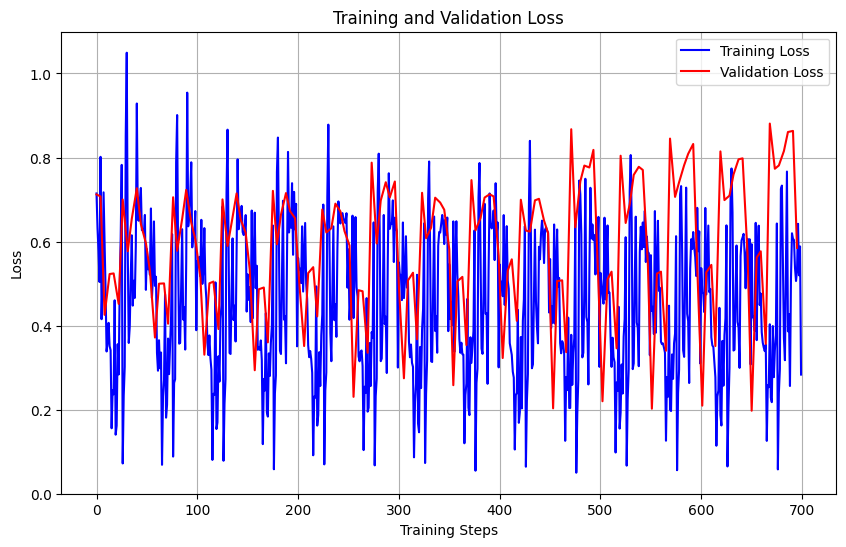

In [58]:
plot_training_history(model)

In [23]:
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, 
                           precision_score, recall_score, fbeta_score, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

def evaluate_model(model: TCNN, X_test: np.ndarray, y_test: np.ndarray, batch_size: int = 32):
    """
    Evaluate model on test set using various metrics.
    
    Parameters:
    -----------
    model : StockCNN
        Trained model
    X_test : np.ndarray
        Test features of shape [n_samples, n_features, lookback]
    y_test : np.ndarray
        Test labels
    batch_size : int
        Batch size for evaluation
    
    Returns:
    --------
    dict
        Dictionary containing various evaluation metrics
    """
    # Create test dataset and loader
    test_dataset = TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False  
    )
    
    # Lists to store predictions and true labels
    y_pred_list = []
    y_true_list = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Iterate through test set
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move batch to model's device
            X_batch = X_batch.to(model.device)
            
            # Get predictions
            y_pred_batch = model(X_batch)
            
            # Store predictions and true labels
            y_pred_list.append(y_pred_batch.cpu().numpy())
            y_true_list.append(y_batch.numpy())
    
    # Concatenate all batches
    y_pred = np.concatenate(y_pred_list).squeeze()
    y_true = np.concatenate(y_true_list)
    
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'F2 Score': fbeta_score(y_true, y_pred_binary, beta=2),
        'F1 Score': fbeta_score(y_true, y_pred_binary, beta=1),
        'Precision': precision_score(y_true, y_pred_binary),
        'Recall': recall_score(y_true, y_pred_binary),
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'AUC': roc_auc_score(y_true, y_pred), 
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred_binary)
    }

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Event', 'Extreme Event'],
                yticklabels=['No Event', 'Extreme Event'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()  
    
    return metrics

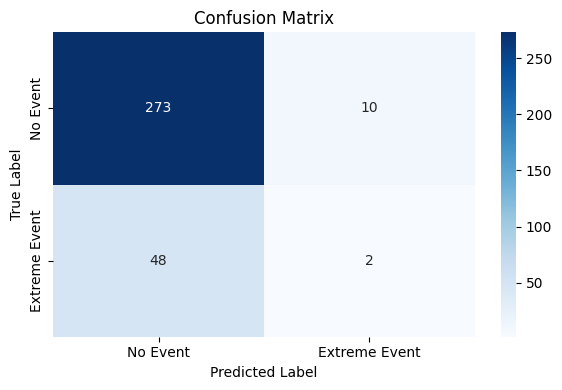

F2 Score            : 0.0472
F1 Score            : 0.0645
Precision           : 0.1667
Recall              : 0.0400
Accuracy            : 0.8258
AUC                 : 0.6481
Balanced Accuracy   : 0.5023
----------------------------------------


In [59]:

metrics = evaluate_model(model, X_test, y_test)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)




# Improvements

## Adding more features

Since we are intrested in predicting extreme events, we will include three additional features that could provide useful information for the task at hand. Specifically, we will include:

-  10-day Rolling Volatility: Periods of high volatility often cluster together, and extreme events are more likely during volatile periods. 
-  Volume Relative to 10-day Moving Average: Unusual trading volume often precedes or accompanies extreme price movements.
- VIX Index: Market-wide volatility often correlates with individual stock extreme movements.

The 10-day window was chosen, since we will be predicting if an extreme event occurs tomorrow based on the past 10 days of data.

In [17]:
from src.data_preprocessing import add_features

stock_prices = add_features(stock_prices, start_date='2015-01-01', end_date='2024-01-31')
stock_prices.head()

ImportError: cannot import name 'add_features' from 'src.data_preprocessing' (/Users/nikolaosmourdoukoutas/ai2c_assignment/src/data_preprocessing.py)